In [25]:
import json
import numpy as np
from energy_consumption import (
    physical_model, 
    battery_power_model, 
    calculate_segment_energy_with_acceleration, 
    discharge_current,
    find_crate
)
import matplotlib.pyplot as plt


In [26]:
with open('vehicle_data.json', 'r') as f:
    vehicle_data = json.load(f)
with open('static_data.json', 'r') as f:
    static_data = json.load(f)
with open('battery_data.json', 'r') as f:
    battery_data = json.load(f)

Test Consumption Calculation

In [27]:
def run_simple_test():
    """
    Simple test for EV energy model using data from JSON files
    """
    segment_data = {'avg_incline_angle': -0.31,
    'climb': -0.0569305419921875,
    'coords': [-2.6119762, 51.4563829, -2.6120352, 51.4563077],
    'distance': 1,
    "velocity": 8,
    "acceleration": 0,
    'points': ['point1', 'point2']}
    
    # Set initial and target velocity
    initial_velocity = 0  # m/s (starting from rest)
    target_velocity = 8  # m/s (90 km/h)
    
    # Extract required values from battery data
    max_motor_power = vehicle_data["max_motor_power"]
    motor_efficiency = vehicle_data["motor_eff"]
    
    # Print input data
    print("=== INPUT DATA ===")
    
    print("\nSegment Data:")
    for key, value in segment_data.items():
        print(f"  {key}: {value}")
    
    print(f"\nInitial Velocity: {initial_velocity} m/s")
    print(f"Target Velocity: {target_velocity} m/s ({target_velocity*3.6:.1f} km/h)")
    
    print("\n=== CALCULATION STEPS ===")
    
    # STEP 1: Calculate forces at constant velocity
    print("\nSTEP 1: Forces at constant velocity")
    
    # Copy segment data with target velocity for constant calculations
    constant_velocity_data = segment_data.copy()
    constant_velocity_data["velocity"] = target_velocity
    constant_velocity_data["acceleration"] = 0
    
    # Calculate individual forces
    avg_incline_angle = np.radians(constant_velocity_data["avg_incline_angle"])
    
    # Force from air resistance
    drag_force = 0.5 * static_data["air_dens"] * vehicle_data["frontal_area"] * vehicle_data["drag_coeff"] * target_velocity**2
    
    # Force from gravity (climbing)
    grav_force = vehicle_data["mass"] * static_data["grav_acc"] * np.sin(avg_incline_angle)
    
    # Force from rolling resistance
    roll_res_force = vehicle_data["mass"] * static_data["grav_acc"] * np.cos(avg_incline_angle) * vehicle_data["roll_res"]
    
    # Calculate total force and power
    total_force = drag_force + grav_force + roll_res_force
    tract_power = total_force * target_velocity
    
    print(f"  Drag Force: {drag_force:.2f} N")
    print(f"  Gravitational Force: {grav_force:.2f} N")
    print(f"  Rolling Resistance: {roll_res_force:.2f} N")
    print(f"  Total Force: {total_force:.2f} N")
    print(f"  Tractive Power: {tract_power:.2f} W")
    
    # STEP 2: Calculate battery power
    print("\nSTEP 2: Battery power")
    
    # Calculate the power required from the battery
    battery_power = battery_power_model(tract_power, motor_efficiency)
    print(f"  Battery Power: {battery_power:.2f} W")
    
    # STEP 3: Full segment energy calculation with acceleration
    print("\nSTEP 3: Full segment energy calculation with acceleration")
    
    # Calculate energy for the segment with acceleration
    energy_result = calculate_segment_energy_with_acceleration(
        initial_velocity, target_velocity, segment_data,
        vehicle_data, static_data, max_motor_power, motor_efficiency
    )
    
    # Print the results
    print("\nAcceleration Analysis:")
    print(f"  Initial Velocity: {energy_result['initial_velocity']:.2f} m/s")
    print(f"  Final Velocity: {energy_result['final_velocity']:.2f} m/s")
    print(f"  Reached Target: {energy_result['reached_target']}")
    print(f"  Acceleration: {energy_result['acceleration']:.4f} m/s²")
    
    if "acceleration_phase" in energy_result:
        print("\nAcceleration Phase:")
        print(f"  Distance: {energy_result['acceleration_phase']['distance']:.2f} m")
        print(f"  Time: {energy_result['acceleration_phase']['time']:.2f} s")
        print(f"  Energy: {energy_result['acceleration_phase']['energy']:.2f} Wh")
        
        print("\nConstant Velocity Phase:")
        print(f"  Distance: {energy_result['constant_phase']['distance']:.2f} m")
        print(f"  Time: {energy_result['constant_phase']['time']:.2f} s")
        print(f"  Energy: {energy_result['constant_phase']['energy']:.2f} Wh")
        
        print("\nTotal:")
        print(f"  Time: {energy_result['total_time']:.2f} s")
        print(f"  Energy: {energy_result['total_energy']:.2f} Wh")
    else:
        print("\nSimple Case (no acceleration phases):")
        print(f"  Time: {energy_result['time']:.2f} s")
        print(f"  Energy: {energy_result['energy_consumption']:.2f} Wh")
    
    # Calculate energy per kilometer
    distance_km = segment_data["distance"] / 1000
    energy_wh = energy_result.get('total_energy', energy_result.get('energy_consumption', 0))
    energy_per_km = energy_wh / distance_km
    
    print("\n=== SUMMARY ===")
    print(f"Total Energy Consumption: {energy_wh:.2f} Wh")
    print(f"Energy per km: {energy_per_km:.2f} Wh/km")

Test Current and C-Rate Calculations

In [28]:
OCV = battery_data["OCV"]
R_i = battery_data["R_internal"]
cap = battery_data["Capacity"]
max_power = vehicle_data["max_motor_power"]

1.2730591207586595


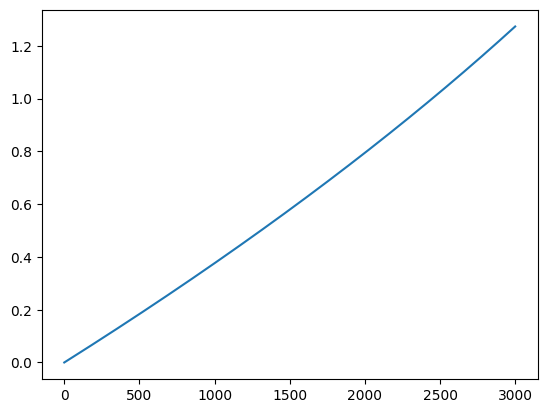